## Setup

In [1]:
import pandas as pd
import logging 
import sys
import os
sys.path.insert(0,'./src')


from src.utils.logger import sys_logger

os.makedirs("./final_data", exist_ok=True)

## Landing Zone to Staging

In [17]:
from src.utils.splitter import split_files

split_files()

[splitter.py:9]                 Files in landing zone: ['products_20241011.json', 'products_20241010.json', 'sales_20241010.txt', 'sales_20241011.txt', 'sales_20241013.txt', 'sales_20241012.txt', 'sales_20241016.txt', 'sales_20241015.txt', 'products_20241016.json', 'sales_20241014.txt', 'products_20241015.json', 'sales_20241009.txt', 'products_20241014.json', 'products_20241009.json', 'customer_20241016.csv', 'products_20241013.json', 'products_20241012.json']
[splitter.py:20]                products_20241011.json did not match with any source
[splitter.py:20]                products_20241010.json did not match with any source
[splitter.py:20]                sales_20241010.txt did not match with any source
[splitter.py:20]                sales_20241011.txt did not match with any source
[splitter.py:20]                sales_20241013.txt did not match with any source
[splitter.py:20]                sales_20241012.txt did not match with any source
[splitter.py:20]                sales_202

## Staging to Tables

In [19]:
from src.utils.ingestion import run_ingestion

run_ingestion()

[watermark.py:8]                Reading watermark table from ./watermark.parquet
[watermark.py:14]               Watermark table has 8 rows
[ingestion.py:12]               Loading customer data
[watermark.py:18]               Getting last run date for customer
[watermark.py:24]               Last run date for customer is 2024-10-16 00:00:00
[files.py:10]                   Getting files to process from ./data/customer/
[files.py:14]                   Found 0 files to process
[ingestion.py:12]               Loading sales data
[watermark.py:18]               Getting last run date for sales
[watermark.py:21]               No previous runs found for sales
[files.py:10]                   Getting files to process from /data/sales/


FileNotFoundError: [Errno 2] No such file or directory: '/data/sales/'

## Report Generation

In [5]:
from matplotlib import pyplot as plt

### Customer Growth

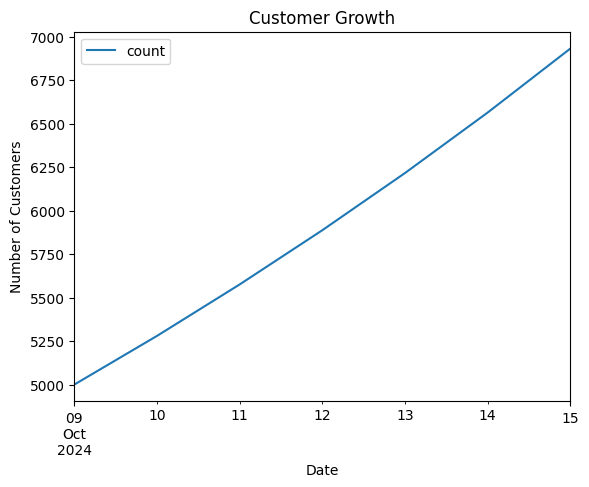

In [6]:
customers = pd.read_parquet('./final_data/customer.parquet')

dates = customers['effective_from'].unique()

data = []
for date in sorted(dates):
    snapshot = customers[(customers['effective_from'] <= date) & (customers['expiry_date'] > date)]
    data.append({'date': date, 'count': len(snapshot)})

df = pd.DataFrame(data)
df.plot(x='date', y='count')
plt.title('Customer Growth')
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.show()

### Sales By Membership

In [ ]:

#cleaning the data


# Load the sales data from the text file using the '~' delimiter and need to include header names as column names are missing
sales_txt_path = './data_for_ticket_2/sales_20241016.txt'
sales_data = pd.read_csv(sales_txt_path, delimiter='~', header=None)

# Check the first few rows to verify the data format
print(sales_data.head())
#sales column names are give as per my understanding it may change as per requirements
sales_data.columns = ['sales_id','customer_id','product_id', 'quantity', 'price_per_unit', 'total_price', 'sale_date']

# Check the first few rows with column names
print(sales_data.head())
# Convert sale_date to datetime
sales_data['sale_date'] = pd.to_datetime(sales_data['sale_date'], format='%Y-%m-%d')

final_data_path = './final_data/sales.parquet'
sales_data.to_parquet(final_data_path)

customers = pd.read_parquet('./final_data/customer.parquet')
sales = pd.read_parquet('./final_data/sales.parquet')

# Check the column names
print("Customer Columns:", customers.columns)
print("Sales Columns:", sales.columns)
#it has column name missing 

                 0                   1      2  3       4       5           6
0  168863177863745  971134716214458594  P5047  1  131.55  131.55  2024-10-16
1  168822124117675  807748605981227390  P9371  3  103.34  310.02  2024-10-16
2  169409181573275  909866518167171808  P6609  2   31.23   62.46  2024-10-16
3  169300935743312  490145165492554048  P5047  1  131.55  131.55  2024-10-16
4  169368363908184  933531419604408947  P8081  2  234.56  469.12  2024-10-16
          sales_id         customer_id product_id  quantity  price_per_unit  \
0  168863177863745  971134716214458594      P5047         1          131.55   
1  168822124117675  807748605981227390      P9371         3          103.34   
2  169409181573275  909866518167171808      P6609         2           31.23   
3  169300935743312  490145165492554048      P5047         1          131.55   
4  169368363908184  933531419604408947      P8081         2          234.56   

  total_price   sale_date  
0      131.55  2024-10-16  
1      

In [9]:

import glob


column_names = ['sales_id', 'customer_id', 'product_id', 'quantity', 'price_per_unit', 'total_price', 'sale_date']

# Define paths for text files in both directories
txt_files_paths = ['./data_for_ticket_2/sales_*.txt', './landing_zone/sales_*.txt']
all_files = [file for path in txt_files_paths for file in glob.glob(path)]

# Load and combine all text files into a single DataFrame with consistent column names
all_data_frames = [pd.read_csv(file, delimiter='~', header=None, names=column_names) for file in all_files]
combined_data = pd.concat(all_data_frames, ignore_index=True)

# Ensure the 'total_price' column has a consistent data type
combined_data['total_price'] = pd.to_numeric(combined_data['total_price'], errors='coerce').fillna(0)

# Convert sale_date to datetime format
combined_data['sale_date'] = pd.to_datetime(combined_data['sale_date'], format='%Y-%m-%d', errors='coerce')

# Save the combined DataFrame as a Parquet file
#to avoid any data corruption we can access the original data 
final_parquet_path = './final_data/sales_combined.parquet'
combined_data.to_parquet(final_parquet_path)

print("Combined data saved to Parquet file.")


Combined data saved to Parquet file.


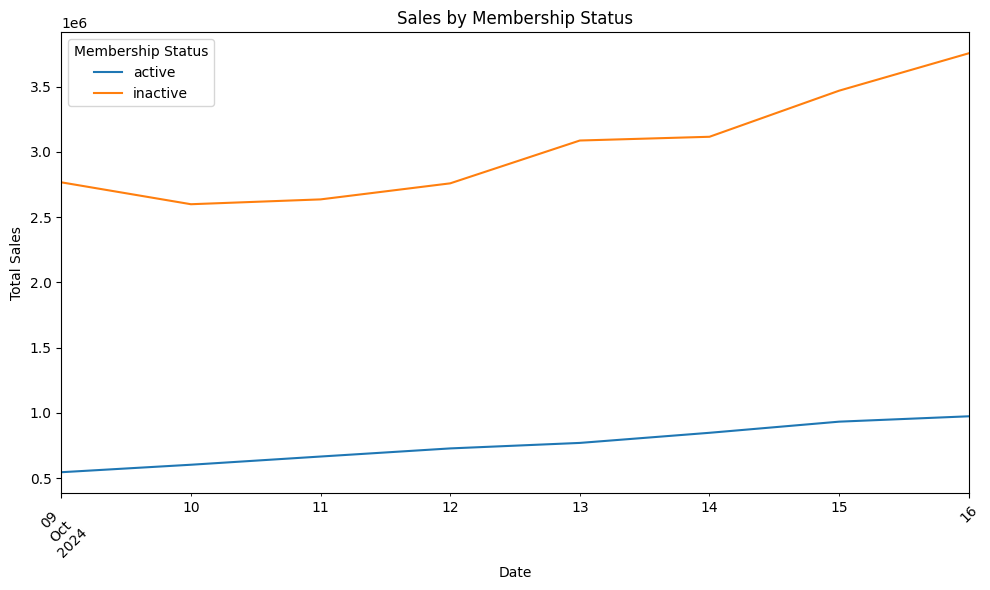

In [ ]:
# Sales By Members
customers = pd.read_parquet('./final_data/customer.parquet')

dates = customers['effective_from'].unique()
sales = pd.read_parquet('./final_data/sales_combined.parquet')
merged = sales.merge(customers, on='customer_id', how='outer')
merged = merged[(merged['effective_from'] <= merged['sale_date']) & (merged['expiry_date'] > merged['sale_date'])]

merged['total_price'] = pd.to_numeric(sales['total_price'], errors='coerce')


data = merged.groupby(['sale_date', 'membership_status'])['total_price'].sum().unstack().fillna(0)


data.plot(figsize=(10, 6))
plt.title('Sales by Membership Status')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend(title='Membership Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#combining multiple data into one


# Define paths for JSON files in both directories
json_files_paths = ['./data_for_ticket_2/products_*.json', './landing_zone/products_*.json']
all_files = [file for path in json_files_paths for file in glob.glob(path)]

# List to store data frames from each JSON file
all_data_frames=[]

for file in all_files:

    try:
        # Attempt to read each JSON file
        print(file)
        product = pd.read_json(file)
        all_data_frames.append(product)
    except ValueError as e:
        print(f"Skipping file {file} due to error: {e}")

# Combine all successfully read DataFrames
if all_data_frames:
    combined_data = pd.concat(all_data_frames, ignore_index=True)
    
    # Save the combined DataFrame as a Parquet file
    final_parquet_path = './final_data/combined_product.parquet'
    combined_data.to_parquet(final_parquet_path)
    print("Combined data saved to Parquet file.")
else:
    print("No valid JSON files found to combine.")

./data_for_ticket_2/products_20241016.json
./landing_zone/products_20241011.json
./landing_zone/products_20241010.json
./landing_zone/products_20241015.json
./landing_zone/products_20241014.json
./landing_zone/products_20241009.json
./landing_zone/products_20241013.json
./landing_zone/products_20241012.json
Combined data saved to Parquet file.


### Product Sale Breakdown

# problem c


In [12]:
# pivot of most popular products over time from members vs non-members

products = pd.read_parquet('./final_data/combined_product.parquet')
customers = pd.read_parquet('./final_data/customer.parquet')
sales = pd.read_parquet('./final_data/sales_combined.parquet')

merged = sales.merge(customers, on='customer_id', how='outer')
merged = merged[(merged['effective_from'] <= merged['sale_date']) & (merged['expiry_date'] > merged['sale_date'])]
merged_with_products = merged.merge(products, on='product_id', how='left')
data = merged_with_products.groupby(['sale_date', 'membership_status', 'name'])['total_price'].sum().unstack().fillna(0)

data


name                              Camera  External Hard Drive  Headphones  \
sale_date  membership_status                                                
2024-10-09 active                   0.00                 0.00        0.00   
           inactive                 0.00                 0.00        0.00   
2024-10-10 active                   0.00                 0.00        0.00   
           inactive                 0.00                 0.00        0.00   
2024-10-11 active                   0.00                 0.00        0.00   
           inactive                 0.00                 0.00        0.00   
2024-10-12 active                   0.00                 0.00   678205.00   
           inactive                 0.00                 0.00  1285350.00   
2024-10-13 active             2550283.20                 0.00   683074.00   
           inactive           4763270.88                 0.00  1316854.00   
2024-10-14 active             2921618.56            215753.46   738180.05   
           inactive           4349880.32            355727.04  1285508.20   
2024-10-15 active             2540523.60            217081.62   696528.00   
           inactive           4409677.60            344829.24  1112832.00   
2024-10-16 active             2654100.24            184771.92   675461.30   
           inactive           4746528.00            360243.24   979100.70   

name                          Keyboard       Laptop     Monitor      Mouse  \
sale_date  membership_status                                                 
2024-10-09 active                  0.0   8816292.80  1628895.60  234393.60   
           inactive                0.0  18353475.84  3694003.92  549964.80   
2024-10-10 active                  0.0   6895058.80  1504407.68  206568.72   
           inactive                0.0  14974209.60  3291128.64  380302.08   
2024-10-11 active                  0.0   6783552.00  1350208.00  197869.44   
           inactive                0.0  12210393.60  2550598.40  360835.84   
2024-10-12 active                  0.0   6034572.96  1435310.72  191368.32   
           inactive                0.0  11031683.52  2590755.84  345384.00   
2024-10-13 active                  0.0   4903997.28  1397400.00  173260.80   
           inactive                0.0   9626657.04  2472480.00  285880.32   
2024-10-14 active                  0.0   4675396.00  1194963.84  145403.04   
           inactive                0.0   7816340.00  2063854.08  261631.36   
2024-10-15 active                  0.0   4209469.28  1269053.76  178456.08   
           inactive                0.0   7140705.44  1908781.68  264039.76   
2024-10-16 active              81561.0   3891299.84  1095864.32  178885.44   
           inactive           156281.4   7803152.32  2163581.44  273574.80   

name                             Printer      Router  Smartphone  Smartwatch  \
sale_date  membership_status                                                   
2024-10-09 active             1587331.20  1550015.04        0.00        0.00   
           inactive           3383962.40  3152942.24        0.00        0.00   
2024-10-10 active             1303281.44  1392053.52        0.00   622643.77   
           inactive           2825822.88  2513116.32        0.00  1250925.97   
2024-10-11 active             1320954.00  1268696.32  3496013.82   570077.20   
           inactive           2788466.40  2266408.96  5925592.92  1166769.45   
2024-10-12 active             1295128.08  1054041.12  3256309.86   620483.85   
           inactive           2427647.76  1859568.48  6413658.06  1033328.66   
2024-10-13 active             1460641.60   952834.24  3059404.32   523596.15   
           inactive           2307418.96  1750524.00  5815709.76  1120546.35   
2024-10-14 active             1348475.68   972127.52  3037824.30   496127.94   
           inactive           2234844.48  1484253.68  4949214.48   923046.81   
2024-10-15 active             1227927.36   812860.48  2910810.36   451376.38   
        

# Ticket 1


In [ ]:
#The top 10 people who purchased the largest number of products
df_all = (
    sales
    .groupby('customer_id')
    ['quantity'].sum()
    .reset_index()
    .sort_values(by='quantity', ascending=False)
    .head(10)
)
df_all = pd.merge(df_all, customers, on='customer_id', how='left')

df_q1=df_all[['customer_id', 'first_name','last_name', 'email', 'quantity']]

# I calculating top 10 ranks people for this calculation [dense Ranking]. we also can go as top 10 rank values...
x=df_q1.drop_duplicates(ignore_index=True)
x.to_csv('./final_results/sales_report.csv', index=False)

In [ ]:
# The top 10 people who purchased the largest number of products while being an active member

df_active = (
    sales
    .groupby('customer_id')['quantity']
    .sum()
    
)

# Merge with customer details to get name and email
df_active = pd.merge(df_active, customers, on='customer_id', how='left')

# Filter for active members only
df_active = df_active[df_active['membership_status'] == 'active']

# Select relevant columns and sort by quantity in descending order, then get top 10
df_top_active = (
    df_active[['customer_id', 'first_name', 'last_name', 'email', 'quantity', 'membership_status']]
    .drop_duplicates(ignore_index=True)  # Remove duplicates, if any
    .sort_values(by='quantity',ignore_index=True ,ascending=False)
    
    .head(10))

df_top_active = df_top_active[[ 'customer_id', 'first_name', 'last_name', 'email', 'quantity', 'membership_status']]

df_top_active.to_csv('./final_results/sales_report_active_member.csv', index=False)



SyntaxError: '(' was never closed (3014280611.py, line 17)

# ticket no 2

I have created 3 scripts for 3 different schema. I can aslo optimize tobe one script

In [95]:

from datetime import datetime
import importlib.util
from pathlib import Path




# Load schema dynamically from schemas.py
schema_path = './src/configs/schemas.py'

spec = importlib.util.spec_from_file_location("schemas", schema_path)
schemas = importlib.util.module_from_spec(spec)
spec.loader.exec_module(schemas)

# Define directories
data_dir = Path('./landing_zone/')
error_dir = Path('./error_reports/')
error_dir.mkdir(exist_ok=True)

def validate_row(row, schema):
    
    errors = []
    
    for field in schema:
        field_name = field["name"]
        field_type = field.get("type")
        required = field.get("required", False)
        value = row.get(field_name)

        # Check for required fields
        if required and pd.isna(value):
            errors.append(f"Field '{field_name}' is required but missing.")
            continue
        
        # Skip validation if value is missing and not required
        if pd.isna(value):
            continue

        # Type validation
        if field_type == "int":
            if not isinstance(value, int):
                errors.append(f"Field '{field_name}' should be of type int, found {type(value).__name__}.")
        
        elif field_type == "string":
            if not isinstance(value, str):
                errors.append(f"Field '{field_name}' should be of type string, found {type(value).__name__}.")

        elif field_type == "float":
            if not isinstance(value, (float, int)):  # Allow integers to pass as floats
                errors.append(f"Field '{field_name}' should be of type float, found {type(value).__name__}.")
        
        elif field_type == "enum":
            valid_values = field.get("values", [])
            if value not in valid_values:
                errors.append(f"Field '{field_name}' has invalid value '{value}'. Expected one of {valid_values}.")
        
        elif field_type == "date":
            date_format = field.get("format", "%Y-%m-%d")
            try:
                datetime.strptime(value, date_format)
            except (ValueError, TypeError):
                errors.append(f"Field '{field_name}' should be a date in the format {date_format}, found '{value}'.")

    return errors

In [ ]:
 #Process each file in the landing zone
for file_path in data_dir.glob('*.csv'):
    print(file_path)
    source_name = file_path.stem
    
    if int(source_name[-8:])>20241015 :
    
        date_str = datetime.now().strftime("%Y%m%d")
        error_file_path = error_dir / f"errors_{source_name}_{date_str}.csv"

        # Load data
        df = pd.read_csv(file_path)
        # print(df)
        schema = schemas.CUSTOMER_SCHEMA  
        # Validate rows
        error_rows = []
        for _, row in df.iterrows():
            row_errors = validate_row(row, schema)
            if row_errors:
                error_row = row.to_dict()
                error_row['errors'] = "; ".join(row_errors)  # Add errors column
                error_rows.append(error_row)

        # Convert error rows to DataFrame and save
        df_errors = pd.DataFrame(error_rows)
        df_errors.to_csv(error_file_path, index=False)

        print(f"Processed {file_path.name}. Errors saved to {error_file_path}.")

print("Daily validation complete.")

landing_zone/customer_20241016.csv
             customer_id first_name  last_name gender  \
0     606112227885144813    Melissa     Zamora      F   
1     127668228483155495      Julia     Conway      F   
2     329841228698711623     Manuel     Crosby      F   
3     325350228911664816     Sherri       Ruiz      F   
4     315880229117534235       Brad   Crawford      M   
...                  ...        ...        ...    ...   
7316   36426031100406185       Kara       King      F   
7317   26523131335109411   Courtney       Carr      U   
7318   19491531600273773    Charles  Robertson      F   
7319   23788431731106898     Rachel      Riley      F   
7320   47043031863574722     Sierra    Navarro      M   

                            email membership_status  \
0            toddmary@example.org          inactive   
1            ajohnson@example.com            active   
2         paigeharris@example.org          inactive   
3               nhall@example.com          inactive   
4    

In [97]:
for file_path in data_dir.glob('*.json'):
    print(file_path)
    source_name = file_path.stem
    
    if int(source_name[-8:])>20241015 :
    
        date_str = datetime.now().strftime("%Y%m%d")
        error_file_path = error_dir / f"errors_{source_name}_{date_str}.csv"

        # Load data
        df = pd.read_json(file_path)
        schema = schemas.PRODUCT_SCHEMA 
        # Validate rows
        error_rows = []
        for _, row in df.iterrows():
            row_errors = validate_row(row, schema)
            if row_errors:
                error_row = row.to_dict()
                error_row['errors'] = "; ".join(row_errors)  # Add errors column
                error_rows.append(error_row)

        # Convert error rows to DataFrame and save
        df_errors = pd.DataFrame(error_rows)
        df_errors.to_csv(error_file_path, index=False)

        print(f"Processed {file_path.name}. Errors saved to {error_file_path}.")

print("Daily validation complete.")



landing_zone/products_20241011.json
landing_zone/products_20241010.json
landing_zone/products_20241016.json
Processed products_20241016.json. Errors saved to error_reports/errors_products_20241016_20241111.csv.
landing_zone/products_20241015.json
landing_zone/products_20241014.json
landing_zone/products_20241009.json
landing_zone/products_20241013.json
landing_zone/products_20241012.json
Daily validation complete.


In [96]:
for file_path in data_dir.glob('*.txt'):
    print(file_path)
    source_name = file_path.stem
    
    if int(source_name[-8:])>20241015 :
        date_str = datetime.now().strftime("%Y%m%d")
        
    
        error_file_path = error_dir / f"errors_{source_name}_{date_str}.csv"

        # Load data
        df = pd.read_csv(file_path,sep='~',header= None)
        schema = schemas.SALES_SCHEMA
        # Validate rows
        error_rows = []
        for _, row in df.iterrows():
            row_errors = validate_row(row, schema)
            if row_errors:
                error_row = row.to_dict()
                error_row['errors'] = "; ".join(row_errors)  # Add errors column
                error_rows.append(error_row)

        # Convert error rows to DataFrame and save
        df_errors = pd.DataFrame(error_rows)
        df_errors.to_csv(error_file_path, index=False)

        print(f"Processed {file_path.name}. Errors saved to {error_file_path}.")

print("Daily validation complete.")


landing_zone/sales_20241010.txt
landing_zone/sales_20241011.txt
landing_zone/sales_20241013.txt
landing_zone/sales_20241012.txt
landing_zone/sales_20241016.txt
Processed sales_20241016.txt. Errors saved to error_reports/errors_sales_20241016_20241111.csv.
landing_zone/sales_20241015.txt
landing_zone/sales_20241014.txt
landing_zone/sales_20241009.txt
Daily validation complete.


In [93]:
for file_path in data_dir.glob('*.*'):
    print(file_path)
    source_name = file_path.stem
    if int(source_name[-8:])>20241015 :
        print('hi')
    else:
        print("bye")


landing_zone/products_20241011.json
bye
landing_zone/products_20241010.json
bye
landing_zone/sales_20241010.txt
bye
landing_zone/sales_20241011.txt
bye
landing_zone/sales_20241013.txt
bye
landing_zone/sales_20241012.txt
bye
landing_zone/sales_20241016.txt
hi
landing_zone/sales_20241015.txt
bye
landing_zone/products_20241016.json
hi
landing_zone/sales_20241014.txt
bye
landing_zone/products_20241015.json
bye
landing_zone/sales_20241009.txt
bye
landing_zone/products_20241014.json
bye
landing_zone/products_20241009.json
bye
landing_zone/customer_20241016.csv
hi
landing_zone/products_20241013.json
bye
landing_zone/products_20241012.json
bye
